In [ ]:
import pandas as pd 
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torch.utils.data as data_utils
import itertools
from sklearn.metrics import confusion_matrix

path = "/datasets/home/73/673/h6gupta/Challenge/challenge_dataset.csv"
data = pd.read_csv(path, header = None)
data = data.convert_objects(convert_numeric=True)

df1 = data.iloc[1:,2:16].values.reshape(205,89,14)

df1 = np.moveaxis(df1, [1,2], [2,1])

labels =[]
for i in range(1,206):
    labels.append(data.iloc[89*i,16])

labels = np.asarray(labels).astype('int64')
print(labels.shape)
print(df1.shape)

In [ ]:
X_train = (df1 - np.mean(df1, axis=0)[None,:,:]) / np.std(df1, axis=0)[None,:,:]

In [ ]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels, stratify = labels, test_size = 0.15)

def one_hot(labels, n_class = 3):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"
    return y

y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)

img = torch.from_numpy(X_tr).float()
lbl = torch.from_numpy(y_tr).float()


batch_size = 40

train = data_utils.TensorDataset(img,lbl)
data_loader = data_utils.DataLoader(train, batch_size = batch_size, shuffle = True)
print(img.size())
print(lbl.size())
print(type(img))
print(type(lbl))


In [4]:
#Hyperparameters

batch_size = 40       # Batch size
seq_len = 89          # Number of steps
learning_rate = 0.0001
num_epochs = 50
n_classes = 3
n_channels = 14

def cross_entropy(input, target):
    logsoftmax = nn.LogSoftmax(dim = 1)
    return torch.mean(torch.mean(-target * logsoftmax(input), dim=1))


In [17]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_channels, 2*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(2*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2))  # 44
        self.layer2 = nn.Sequential(
            nn.Conv1d(2*n_channels,  4*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(4*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)) # 22
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(4*n_channels,  8*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)) ## 11
            
        self.layer4 = nn.Sequential(
            nn.Conv1d(8*n_channels,  16*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2)) # 5
        
        self.layer5 = nn.Sequential(nn.Linear(5*16*n_channels, num_classes),nn.Softmax())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer5(out)
        return out

    
def Network_Initialization(model):
    if(type(model) == nn.Linear):
        torch.nn.init.xavier_uniform_(model.weight)
        model.bias.data.fill_(0.01)
    if(type(model) == nn.Conv1d):
        torch.nn.init.normal_(model.weight.data, 0.0, 0.01)
    if(type(model) == nn.BatchNorm1d):
        torch.nn.init.normal_(model.weight.data, 1.0, 0.01)
        torch.nn.init.constant_(model.bias.data, 0.0)
        
        
model = ConvNet(n_classes)
model.apply(Network_Initialization)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
yinit = model(img)

Testing Accuracy: 0.23


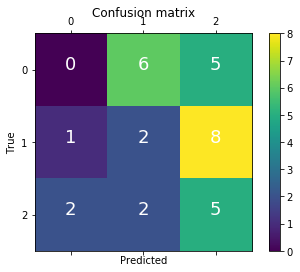

In [18]:
def accuracy(yinit, lbl):
    _, predicted = torch.max(yinit.data, 1)
    classifications = ((predicted == torch.max(lbl.data, 1)[1]).sum().item())
    return classifications

img_v1 = torch.from_numpy(X_vld).float()
lbl_v1 = torch.from_numpy(y_vld).float()
yinit_v1 = model(img_v1)

print("Testing Accuracy: {0:.2f}".format(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0])))

preds= torch.max(yinit_v1.data, 1)[1].numpy()
true = torch.max(lbl_v1.data, 1)[1].numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),horizontalalignment="center",color="white", fontsize=18)
plt.show()

In [19]:
train_acc = []
test_acc =  []
acc = 0
for epoch in range(num_epochs):
    mc = 0
    for i, (images, labels) in enumerate(data_loader):
        outputs = model(images)
        loss = cross_entropy(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mc += accuracy(outputs, labels)

    yinit_v1 = model(img_v1)
    test_acc.append(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0]))
    train_acc.append(mc/float(img.shape[0]))
    print(epoch, loss.item(), mc/float(img.shape[0]), accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0]))
    
    if((accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0])) > acc ):
        torch.save(model.state_dict(), 'CNNModel.pth')
        acc = (accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0]))
        print('Model File Saved !')

(0, 0.34807732701301575, 0.367816091954023, 0.6774193548387096)
Model File Saved !
(1, 0.331714004278183, 0.632183908045977, 0.6129032258064516)
(2, 0.31115078926086426, 0.7413793103448276, 0.6451612903225806)
(3, 0.26165100932121277, 0.764367816091954, 0.6129032258064516)
(4, 0.26178985834121704, 0.8103448275862069, 0.5806451612903226)
(5, 0.2400638312101364, 0.8620689655172413, 0.6451612903225806)
(6, 0.3185662627220154, 0.8563218390804598, 0.6774193548387096)
(7, 0.2362857162952423, 0.8908045977011494, 0.6129032258064516)
(8, 0.219832181930542, 0.9137931034482759, 0.6451612903225806)
(9, 0.22191493213176727, 0.9252873563218391, 0.6774193548387096)
(10, 0.20568633079528809, 0.9482758620689655, 0.6451612903225806)
(11, 0.2605264186859131, 0.9195402298850575, 0.7096774193548387)
Model File Saved !
(12, 0.24143251776695251, 0.9482758620689655, 0.6774193548387096)
(13, 0.21673741936683655, 0.9597701149425287, 0.7096774193548387)
(14, 0.21444019675254822, 0.9655172413793104, 0.77419354838

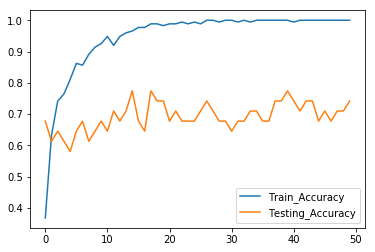

In [20]:
t = np.arange(num_epochs)
plt.plot(t, train_acc)
plt.plot(t, test_acc)
plt.legend(['Train_Accuracy', 'Testing_Accuracy'])
plt.show()

In [21]:
model = ConvNet(n_classes)
model.load_state_dict(torch.load('CNNModel.pth'))
yinit_v1 = model(img_v1)
print("Testing Accuracy: {0:.2f}".format(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0])))

Testing Accuracy: 0.77


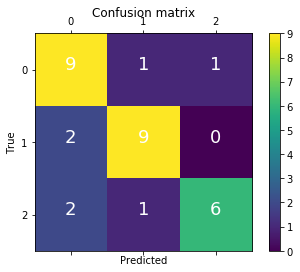

In [22]:
preds= torch.max(yinit_v1.data, 1)[1].numpy()
true = torch.max(lbl_v1.data, 1)[1].numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),horizontalalignment="center",color="white", fontsize=18)
plt.show()